[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Trusted-AI/AIF360/blob/main/examples/sklearn/monthly_bee_datasets_metrics.ipynb)

# Method of the month (July) -- Dataset loading and running metrics

In [1]:
#Install AIF360
!pip install 'aif360' 

In [2]:
import pandas as pd
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from aif360.sklearn.datasets import fetch_adult, standardize_dataset
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error
from aif360.sklearn.metrics import base_rate, ratio

## Loading data

Datasets are formatted as separate `X` (# samples x # features) and `y` (# samples x # labels) DataFrames. The index of each DataFrame contains protected attribute values per sample. Datasets may also load a `sample_weight` object to be used with certain algorithms/metrics. All of this makes it so that aif360 is compatible with scikit-learn objects.

For example, we can easily load the Adult dataset from UCI with the following line:

In [3]:
X, y, sample_weight = fetch_adult(binary_race=False)
X.head()

age  workclass     education  education-num      marital-status  \
race  sex                                                                      
Black Male  25.0    Private          11th            7.0       Never-married   
White Male  38.0    Private       HS-grad            9.0  Married-civ-spouse   
      Male  28.0  Local-gov    Assoc-acdm           12.0  Married-civ-spouse   
Black Male  44.0    Private  Some-college           10.0  Married-civ-spouse   
White Male  34.0    Private          10th            6.0       Never-married   

                   occupation   relationship   race   sex  capital-gain  \
race  sex                                                                 
Black Male  Machine-op-inspct      Own-child  Black  Male           0.0   
White Male    Farming-fishing        Husband  White  Male           0.0   
      Male    Protective-serv        Husband  White  Male           0.0   
Black Male  Machine-op-inspct        Husband  Black  Male        7688.0   
White Male      Other-service  Not-in-family  White  Male           0.0   

            capital-loss  hours-per-week native-country  
race  sex                                                
Black Male           0.0            40.0  United-States  
White Male           0.0            50.0  United-States  
      Male           0.0            40.0  United-States  
Black Male           0.0            40.0  United-States  
White Male           0.0            30.0  United-States

The protected attribute information is also replicated in the labels (this will be useful when running metics):

In [4]:
y.head()

race   sex 
Black  Male    <=50K
White  Male    <=50K
       Male     >50K
Black  Male     >50K
White  Male    <=50K
Name: annual-income, dtype: category
Categories (2, object): ['<=50K' < '>50K']

By default, this will drop rows which include missing (NA) values. Changing the `dropna` arg will allow us to handle those samples differently, if we so choose.

In [5]:
X_num, y_num, _ = fetch_adult(dropna=False)
X.shape, X_num.shape

((45222, 13), (48842, 13))

There are a number of other arguments one can explore. For example, the `numeric_only` arg will _drop_ all non-numeric columns (this will be useful for running `DisparateImpactRemover`). This is equivalent to using the `usecols` or `dropcols` arguments. Finally, these can all be done manually as well since the data are simply Pandas data types but it is convenient, especially when combined with `dropna` to use the provided interface.

We can then split the dataset

In [6]:
(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, train_size=0.7, random_state=1234567)

and one-hot encode the categorical features:

In [7]:
import pandas as pd
from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone


class PandasMeta(BaseEstimator, MetaEstimatorMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None, **fit_params):
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(X, y, **fit_params)
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        output = self.estimator_.transform(X)
        if not isinstance(output, pd.DataFrame):
            output = pd.DataFrame(output, index=X.index)
            try:
                columns = self.estimator_.get_feature_names_out()
                output.columns = columns
            except:
                pass
        return output
    
    def fit_transform(self, X, y=None, **fit_params):
        assert isinstance(X, pd.DataFrame)
        self.estimator_ = clone(self.estimator)
        output = self.estimator_.fit_transform(X, y, **fit_params)
        if not isinstance(output, pd.DataFrame):
            output = pd.DataFrame(output, index=X.index)
            try:
                columns = self.estimator_.get_feature_names_out()
                output.columns = columns
            except:
                pass
        return output

In [8]:
pre = make_column_transformer(
        (OneHotEncoder(sparse=False), X_train.dtypes == 'category'),
        (StandardScaler(), X_train.dtypes != 'category'),
        verbose_feature_names_out=False)
pre = PandasMeta(pre)
pre.fit_transform(X_train)

workclass_Federal-gov  workclass_Local-gov  workclass_Private  \
race  sex                                                                     
White Male                      0.0                  0.0                0.0   
      Female                    0.0                  0.0                0.0   
      Male                      0.0                  0.0                1.0   
      Male                      0.0                  0.0                1.0   
      Male                      0.0                  0.0                1.0   
...                             ...                  ...                ...   
      Male                      0.0                  0.0                1.0   
      Male                      0.0                  0.0                1.0   
      Male                      0.0                  0.0                0.0   
      Male                      0.0                  0.0                1.0   
Black Male                      0.0                  0.0                1.0   

              workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
race  sex                                                          
White Male                       0.0                         1.0   
      Female                     0.0                         1.0   
      Male                       0.0                         0.0   
      Male                       0.0                         0.0   
      Male                       0.0                         0.0   
...                              ...                         ...   
      Male                       0.0                         0.0   
      Male                       0.0                         0.0   
      Male                       1.0                         0.0   
      Male                       0.0                         0.0   
Black Male                       0.0                         0.0   

              workclass_State-gov  workclass_Without-pay  education_10th  \
race  sex                                                                  
White Male                    0.0                    0.0             0.0   
      Female                  0.0                    0.0             0.0   
      Male                    0.0                    0.0             0.0   
      Male                    0.0                    0.0             0.0   
      Male                    0.0                    0.0             1.0   
...                           ...                    ...             ...   
      Male                    0.0                    0.0             0.0   
      Male                    0.0                    0.0             0.0   
      Male                    0.0                    0.0             0.0   
      Male                    0.0                    0.0             0.0   
Black Male                    0.0                    0.0             0.0   

              education_11th  education_12th  ...  native-country_Thailand  \
race  sex                                     ...                            
White Male               0.0             0.0  ...                      0.0   
      Female             0.0             0.0  ...                      0.0   
      Male               0.0             0.0  ...                      0.0   
      Male               0.0             0.0  ...                      0.0   
      Male               0.0             0.0  ...                      0.0   
...                      ...             ...  ...                      ...   
      Male               0.0             0.0  ...                      0.0   
      Male               0.0             0.0  ...                      0.0   
      Male               0.0             0.0  ...                      0.0   
      Male               0.0             0.0  ...                      0.0   
Black Male               0.0             0.0  ...                      0.0   

              native-country_Trinadad&Tobago  native-country_United-States  \
race  sex          

## Running metrics

Now, we can get a baseline measurement for disparate impact ratio on the training data:

In [9]:
di_train = disparate_impact_ratio(y_train, prot_attr='sex', priv_group='Male', pos_label='>50K')
di_train

0.36011001703880235

Sidenote: this is equivalent to:

In [10]:
ratio(base_rate, y_train, prot_attr='sex', priv_group='Male', pos_label='>50K')

0.36011001703880235

With the data in this format, we can easily train a scikit-learn model and get predictions for the test data:

In [11]:
model = LogisticRegression(max_iter=1000)
grid = GridSearchCV(model, param_grid={'C': [1, 10]})
pipe = make_pipeline(pre, grid)

y_pred = pipe.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_pred)

0.8461708557529299

In [12]:
pipe.named_steps['gridsearchcv'].best_params_

{'C': 1}

Now, we can analyze our predictions and quickly calucate the disparate impact for females vs. males:

In [13]:
di_test = disparate_impact_ratio(y_test, y_pred, prot_attr='sex', priv_group='Male', pos_label='>50K')
di_test

0.3006936739406486

We can see our model (without mitigation) has worsened the disparate impact compared to the baseline present in the data itself.

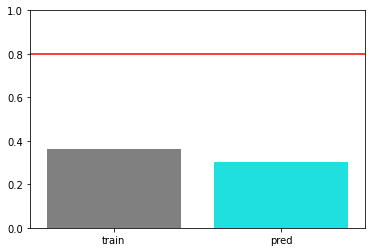

In [14]:
ax = sns.barplot(x=['train', 'pred'], y=[di_train, di_test], palette=['gray', 'aqua'])
ax.axes.set_ylim([0, 1]);
ax.axes.axhline(y=0.8, c='r');

And similarly, we can assess how close the predictions are to equality of odds.

`average_odds_error()` computes the (unweighted) average of the absolute values of the true positive rate (TPR) difference and false positive rate (FPR) difference, i.e.:

$$ \tfrac{1}{2}\left(|FPR_{D = \text{unprivileged}} - FPR_{D = \text{privileged}}| + |TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}}|\right) $$

In [15]:
average_odds_error(y_test, y_pred, priv_group=('White', 'Male'), pos_label='>50K')

0.08822379061098651

In that case, we chose to look at the intersection of all protected attributes (race and sex) and designate a single combination (white males) as privileged.

## Load a custom dataset

We can just as easily load a dataset other than the ones included out-of-the-box. As an example, let us examine the ubiquitous Titanic dataset:

In [16]:
from sklearn.datasets import fetch_openml

X_ti, y_ti = fetch_openml("titanic", version=1, return_X_y=True)
X_ti.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


In [17]:
y_ti = y_ti.astype(int)
y_ti.head()

0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: int64

We use the `standardize_dataset` function to handle some of the preprocessing and protected attribute storage. We will only look at "age", "sex", "pclass" (passenger class), and "fare". We also drop samples with missing values.

In [18]:
X_ti, y_ti = standardize_dataset(X_ti, prot_attr='pclass', target=y_ti, usecols=['age', 'sex', 'pclass', 'fare'])
X_ti

,age,sex,pclass,fare
pclass,,,,
1.0,29.0000,female,1.0,211.3375
1.0,0.9167,male,1.0,151.5500
1.0,2.0000,female,1.0,151.5500
1.0,30.0000,male,1.0,151.5500
1.0,25.0000,female,1.0,151.5500
...,...,...,...,...
3.0,45.5000,male,3.0,7.2250
3.0,14.5000,female,3.0,14.4542
3.0,26.5000,male,3.0,7.2250


Class 1 passengers paid more for their tickets so we can assume they were of higher socio-economic status.

In [19]:
X_ti.groupby(X_ti.pclass).fare.mean()

pclass
1.0    92.229358
2.0    21.855044
3.0    12.879299
Name: fare, dtype: float64

They also were about twice as likely to survive as non-first class passengers:

In [20]:
disparate_impact_ratio(y_ti, priv_group=1)

0.5072128124523562